In [1]:
import pandas as pd
import numpy as np
import pymc3
import matplotlib.pyplot as plt
from plotnine import *
import itertools
import statsmodels.api as sm
from pylab import rcParams
import plotly.express as px
df = pd.read_csv('sac_animals.csv')


df['intake_date'] = pd.to_datetime(df['intake_date'])
df['outcome_date'] = pd.to_datetime(df['outcome_date'])
df['n'] = 1

df = df.set_index('intake_date')
df_nostray = df[df['intake_type'] != 'STRAY']

y = df['n'].resample('W').sum()
y = y[(y.index > '2017-12-03') & (y.index < '2020-12-06')]

y_nostray = df_nostray['n'].resample('W').sum()
y_nostray = y_nostray[(y_nostray.index > '2017-12-03') & (y_nostray.index < '2020-12-06')]


mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

mod_nostray = sm.tsa.statespace.SARIMAX(y_nostray,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
results = mod.fit()
results_nostray = mod_nostray.fit()

pred = results.get_prediction(start=pd.to_datetime('2020-07-05 00:00:00+00:00'), dynamic=False)
pred_nostray = results_nostray.get_prediction(start=pd.to_datetime('2020-07-05 00:00:00+00:00'), dynamic=False)


pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

pred_uc_nostray = results_nostray.get_forecast(steps=100)
pred_ci_nostray = pred_uc_nostray.conf_int()

all_preds = y.append(pred_uc.predicted_mean).to_frame()
preds_and_ci = all_preds.merge(pred_ci, left_on=all_preds.index, right_on=pred_ci.index, how='left')
preds_and_ci.columns = ['date', 'average', 'lower_bound', 'upper_bound']
preds_long = preds_and_ci.melt(id_vars='date')

all_preds_nostray = y_nostray.append(pred_uc_nostray.predicted_mean).to_frame()
preds_and_ci_nostray = all_preds_nostray.merge(pred_ci_nostray, left_on=all_preds_nostray.index, right_on=pred_ci_nostray.index, how='left')
preds_and_ci_nostray.columns = ['date', 'average', 'lower_bound', 'upper_bound']
preds_long_nostray = preds_and_ci_nostray.melt(id_vars='date')

preds_long_nostray['scaled_value'] = preds_long_nostray['value'] * 2.7

/Users/justingoss/Desktop/sac_animals/sac_animals/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


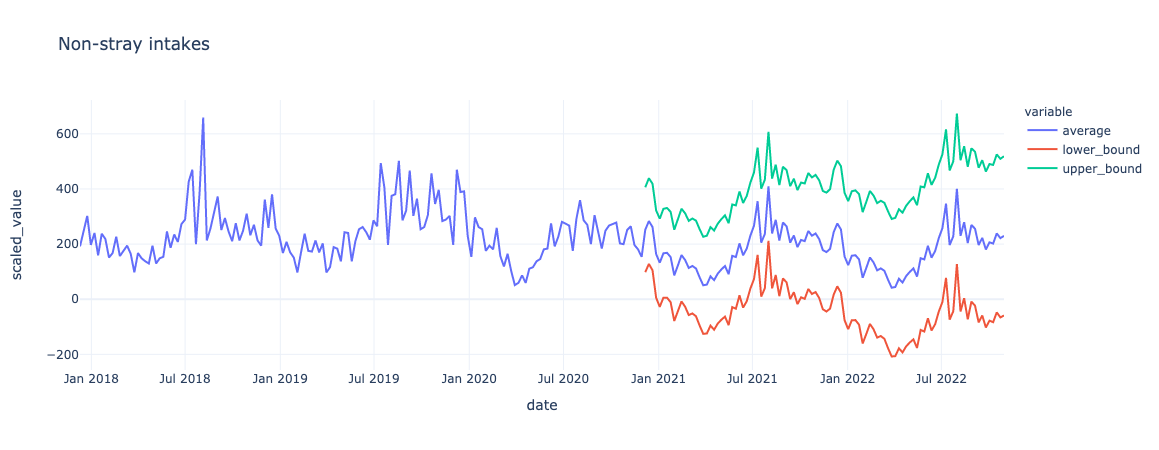

In [4]:
fig_nostray = px.line(preds_long_nostray, x="date", y="scaled_value", color='variable', title='Non-stray intakes', template='plotly_white')

fig_nostray.show()

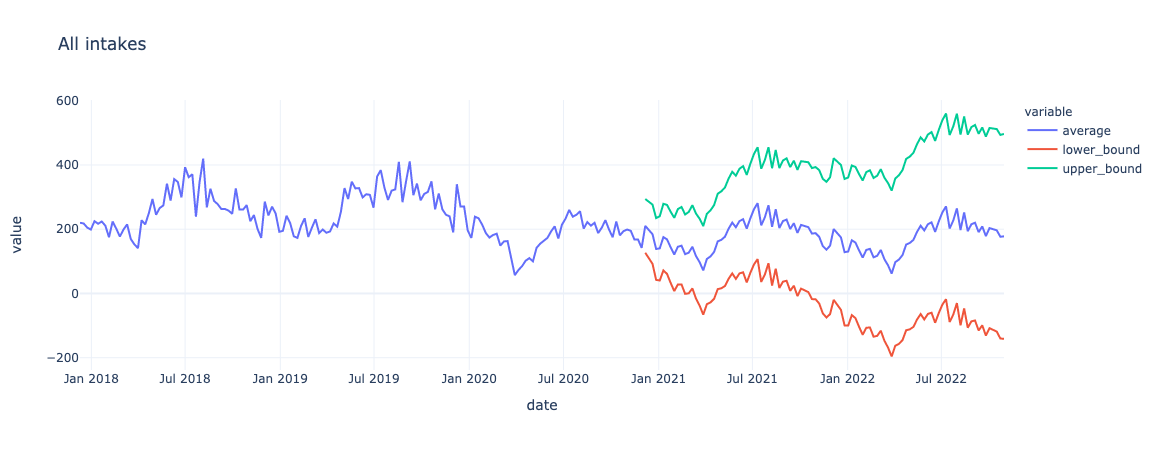

In [3]:
fig = px.line(preds_long, x="date", y="value", color='variable', title='All intakes', template='plotly_white')
fig.show()